In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler  

# Path to the CSV file containing the HTRU2 data
csv_file_path = '/home/afk/Documents/new/QRA/pulsar.csv'  

# Load the CSV file into a pandas DataFrame
data = pd.read_csv(csv_file_path)

# Print the first few rows of the dataframe to understand its structure
print(data.head())

# Assume the last column is the label and all other columns are features
X = data.iloc[:, :-1].values  # Feature columns
y = data.iloc[:, -1].values   # Label column

# Print label distribution to confirm that 0 represents non-pulsar and 1 represents pulsar
print("\nLabel distribution:")
print(f"0 (Non-pulsar): {np.sum(y == 0)} instances")
print(f"1 (Pulsar): {np.sum(y == 1)} instances")

# Normalize the features to the range [0, 1]
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

# Create a dataset list of dictionaries for shuffling
np_data_set = [{'features': features, 'label': label} for features, label in zip(X_normalized, y)]

# Shuffle the dataset
np.random.shuffle(np_data_set)

# Print the first 5 samples of the shuffled data
print("\nFirst 5 samples of encoded shuffled data:")
for sample in np_data_set[:5]:
    print(f"Features: {sample['features']}, Label: {sample['label']}")

# Extract shuffled features and labels
shuffled_features = np.array([sample['features'] for sample in np_data_set])
shuffled_labels = np.array([sample['label'] for sample in np_data_set])

# Perform a stratified split
train_features, test_features, train_labels, test_labels = train_test_split(
    shuffled_features,
    shuffled_labels,
    test_size=0.3,  # 30% of the data for testing
    stratify=shuffled_labels,  # Ensures proportional splits
    random_state=42  # For reproducibility
)

# Assign variables for train and test datasets
train_data = {'features': train_features, 'labels': train_labels}
test_data = {'features': test_features, 'labels': test_labels}

# Print the shapes of the training and test datasets
print(f"\nTraining features shape: {train_data['features'].shape}")
print(f"Training labels shape: {train_data['labels'].shape}")
print(f"Test features shape: {test_data['features'].shape}")
print(f"Test labels shape: {test_data['labels'].shape}")

# Count the number of instances of each label in the training and test datasets
train_label_counts = np.bincount(train_data['labels'])
test_label_counts = np.bincount(test_data['labels'])

print("\nLabel counts in the training dataset:")
print(f"0 (Non-pulsar): {train_label_counts[0]} instances")
print(f"1 (Pulsar): {train_label_counts[1]} instances")

print("\nLabel counts in the test dataset:")
print(f"0 (Non-pulsar): {test_label_counts[0]} instances")
print(f"1 (Pulsar): {test_label_counts[1]} instances")



   mean_int_pf     std_pf  ex_kurt_pf   skew_pf   mean_dm     std_dm  \
0   140.562500  55.683782   -0.234571 -0.699648  3.199833  19.110426   
1   102.507812  58.882430    0.465318 -0.515088  1.677258  14.860146   
2   103.015625  39.341649    0.323328  1.051164  3.121237  21.744669   
3   136.750000  57.178449   -0.068415 -0.636238  3.642977  20.959280   
4    88.726562  40.672225    0.600866  1.123492  1.178930  11.468720   

     kurt_dm     skew_dm  class  
0   7.975532   74.242225      0  
1  10.576487  127.393580      0  
2   7.735822   63.171909      0  
3   6.896499   53.593661      0  
4  14.269573  252.567306      0  

Label distribution:
0 (Non-pulsar): 16259 instances
1 (Pulsar): 1639 instances

First 5 samples of encoded shuffled data:
Features: [0.59386893 0.3340538  0.19798896 0.02278217 0.01586231 0.14281846
 0.25878998 0.04143285], Label: 0
Features: [0.51127096 0.18118657 0.25077092 0.04353242 0.00809225 0.11223817
 0.34817993 0.08783486], Label: 0
Features: [0.57647

In [11]:
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
#from qiskit import IBMQ
from qiskit.providers.basic_provider import BasicProvider


num_clients = 2   #5
num_epochs = 5  #25
max_train_iterations = 10
samples_per_epoch= 100
#backend = Aer.get_backend('aer_simulator')
backend = BasicProvider().get_backend("basic_simulator")


fl_avg_weight_range = [0.1, 1]


In [34]:
class Client:
    def __init__(self, data):
        self.models = []
        self.primary_model = None
        self.data = data
        self.test_scores = []
        self.train_scores = []

def split_dataset(num_clients, num_epochs, samples_per_epoch, train_data):
    clients = []
    for i in range(num_clients):
        client_data = []
        for j in range(num_epochs):
            start_idx = (i * num_epochs * samples_per_epoch) + (j * samples_per_epoch)
            end_idx = (i * num_epochs * samples_per_epoch) + ((j + 1) * samples_per_epoch)
            images = train_data['features'][start_idx:end_idx]
            labels = train_data['labels'][start_idx:end_idx]
            epoch_data = [{'features': img, 'labels': lbl} for img, lbl in zip(images, labels)]
            client_data.append(epoch_data)
        clients.append(Client(client_data))
    return clients

# Example usage:
clients = split_dataset(num_clients, num_epochs, samples_per_epoch, train_data)
# Check the label distribution for the first epoch of the first client
for idx, client in enumerate(clients):
    labels = [data_point['labels'] for data_point in client.data[0]]  # Access the 'labels' key for the first epoch of the first client
    unique_labels, counts = np.unique(labels, return_counts=True)
    print(f"Client {idx}, Epoch 0 - Labels: {dict(zip(unique_labels, counts))}")


Client 0, Epoch 0 - Labels: {0: 90, 1: 10}
Client 1, Epoch 0 - Labels: {0: 93, 1: 7}


In [35]:
 #Define the callback function for the optimizer
itr = 0
def training_callback(weights, obj_func_eval):
    global itr
    itr += 1
    print(f"{itr}", end=' | ')

# Define the training function
def train(data, model=None):
    # Ensure 'data' is a list of dictionaries with 'features' and 'labels'
    if isinstance(data, list) and len(data) > 0 and 'features' in data[0] and 'labels' in data[0]:
        train_features = [data_point["features"] for data_point in data]
        train_labels = [data_point["labels"] for data_point in data]
    else:
        raise ValueError("Data must be a list of dictionaries with 'features' and 'labels' keys.")
    
    # Convert the lists to NumPy arrays
    train_features = np.array(train_features)
    train_labels = np.array(train_labels)

    # Print the shapes
    print("Train features Shape:", train_features.shape)
    print("Train Labels Shape:", train_labels.shape)

    # Create a new model if one is not provided
    if model is None:
        num_features = len(train_features[0])
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
        ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
        optimizer = COBYLA(maxiter=max_train_iterations)  # Ensure `max_train_iterations` is defined
        #backend = Aer.get_backend('aer_simulator')  # Choose the appropriate backend
        model = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            callback=partial(training_callback),
            sampler=BackendSampler(backend=backend),
            warm_start=True
        )

    # Training
    print("Training Started")
    start_time = time.time()
    model.fit(train_features, train_labels)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\nTraining complete. Time taken: {elapsed_time} seconds.")

    # Scoring
    print("SCORING MODEL")
    train_score_q = model.score(train_features, train_labels)
    test_score_q = model.score(test_features, test_labels)

    return train_score_q, test_score_q, model

In [36]:
# Define the function to get accuracy of the model with specific weights
def getAccuracy(weights, test_num=200):
    # Ensure the number of samples for testing does not exceed available data
    test_num = min(test_num, len(test_features))  # Adjust to available test data size

    # Define the feature map and ansatz
    num_features = len(test_features[0])
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    optimizer = COBYLA(maxiter=0)  # No optimization; we only evaluate accuracy

    # Create the VQC model with the provided weights
    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        sampler=BackendSampler(backend=backend),
        initial_point=weights  # Use the provided weights
    )
    
    # Train the model on a small subset of the test data (for quick evaluation)
    vqc.fit(test_features[:25], test_labels[:25])
    
    # Evaluate accuracy on the specified number of test samples
    accuracy = vqc.score(test_features[:test_num], test_labels[:test_num])
    return accuracy

# Define the function to create a VQC model with specific weights
def create_model_with_weights(weights):
    # Define the feature map and ansatz
    num_features = len(test_features[0])
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
    optimizer = COBYLA(maxiter=max_train_iterations)  # Set the number of iterations for the optimizer

    # Create the VQC model with the provided weights
    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        sampler=BackendSampler(backend=backend),
        warm_start=True,
        initial_point=weights,  # Use the provided weights
        callback=partial(training_callback)
    )
    return vqc

In [37]:
import warnings

# Temporary code to suppress all FutureWarnings for a cleaner output
warnings.simplefilter("ignore", FutureWarning)


In [38]:
import numpy as np

def sort_epoch_results(epoch_results):
    # Pair weights and test_scores together
    pairs = zip(epoch_results['weights'], epoch_results['test_scores'])

    # Sort the pairs based on test_scores
    sorted_pairs = sorted(pairs, key=lambda x: x[1])

    # Unzip the sorted pairs back into separate arrays
    sorted_weights, sorted_test_scores = zip(*sorted_pairs)

    # Create a new sorted dictionary
    sorted_epoch_results = {
        'weights': list(sorted_weights),
        'test_scores': list(sorted_test_scores)
    }

    return sorted_epoch_results
fl_avg_weight_range = [0.1, 1]

def scale_test_scores(sorted_epoch_results):
    min_test_score = sorted_epoch_results['test_scores'][0]
    max_test_score = sorted_epoch_results['test_scores'][-1]
    min_weight, max_weight = fl_avg_weight_range
    scaled_weights = [
        min_weight + (max_weight - min_weight) * (test_score - min_test_score) / (max_test_score - min_test_score)
        for test_score in sorted_epoch_results['test_scores']
    ]
    sorted_epoch_results['fl_avg_weights'] = scaled_weights
    return sorted_epoch_results

def calculate_weighted_average(model_weights, fl_avg_weights):
    weighted_sum_weights = []
    for index in range(len(model_weights[0])):
      weighted_sum_weights.append(0)
      weighted_sum_weights[index] = sum([(weights_array[index]* avg_weight) for weights_array, avg_weight  in zip(model_weights, fl_avg_weights)])/sum(fl_avg_weights)
    return weighted_sum_weights

def weighted_average(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)
  epoch_results = sort_epoch_results(epoch_results)
  epoch_results = scale_test_scores(epoch_results)
  print(epoch_results)
  weighted_average_weights_curr_epoch = calculate_weighted_average(epoch_results['weights'], epoch_results['fl_avg_weights'])
  return weighted_average_weights_curr_epoch



def weighted_average_best_pick(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None, best_pick_cutoff = 0.5):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)

  epoch_results = sort_epoch_results(epoch_results)
  epoch_results = scale_test_scores(epoch_results)

  new_weights = []
  new_test_scores = []
  new_fl_avg_weights = []

  for index, fl_avg_weight in enumerate(epoch_results['fl_avg_weights']):
      if fl_avg_weight >= best_pick_cutoff:
          new_weights.append(epoch_results['weights'][index])
          new_test_scores.append(epoch_results['test_scores'][index])
          new_fl_avg_weights.append(fl_avg_weight)

  # Update the epoch_results dictionary with the new lists
  epoch_results['weights'] = new_weights
  epoch_results['test_scores'] = new_test_scores
  epoch_results['fl_avg_weights'] = new_fl_avg_weights

  print(epoch_results)
  weighted_average_weights_curr_epoch = calculate_weighted_average(epoch_results['weights'], epoch_results['fl_avg_weights'])
  return weighted_average_weights_curr_epoch

def simple_averaging(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)

  epoch_weights = epoch_results['weights']
  averages = []
  # Iterate through the columns (i.e., elements at the same position) of the arrays
  for col in range(len(epoch_weights[0])):
      # Initialize a variable to store the sum of elements at the same position
      col_sum = 0
      for row in range(len(epoch_weights)):
          col_sum += epoch_weights[row][col]

      # Calculate the average for this column and append it to the averages list
      col_avg = col_sum / len(epoch_weights)
      averages.append(col_avg)

  return averages



In [39]:

fl_techniques = {
    'Averaging': simple_averaging,
    'Weighted_Averaging': weighted_average,
    'Best_Pick_Weighted_Averaging': weighted_average_best_pick
}
clients_2d_array = [[] for _ in range(len(fl_techniques))]

for index, (technique_name, _) in enumerate(fl_techniques.items()):
        for client in clients:
          client_copy = Client(client.data)
          clients_2d_array[index].append(client_copy)


clients_2d_array

[[<__main__.Client at 0x7f11dae33e30>, <__main__.Client at 0x7f11db804440>],
 [<__main__.Client at 0x7f11dadd7800>, <__main__.Client at 0x7f11dadd6030>],
 [<__main__.Client at 0x7f11dadd63f0>, <__main__.Client at 0x7f11dadd73b0>]]

In [40]:
global_model_weights = []
global_model_accuracy = []

for outer_idx, clients in enumerate(clients_2d_array):
    technique_name = list(fl_techniques.keys())[outer_idx]
    technique_function = list(fl_techniques.values())[outer_idx]
    print(f"Technique Name: {technique_name}")
    global_model_weights.append([])
    global_model_accuracy.append([])

    for epoch in range(num_epochs):
        epoch_results = {
            'weights': [],
            'test_scores': []
        }
        print(f"Epoch: {epoch}")

        for index, client in enumerate(clients):
            print(f"Index: {index}, Client: {client}")

            client_data = client.data[epoch]

            if client.primary_model is None:
                train_score_q, test_score_q, model = train(data=client_data)
                client.models.append(model)
                client.test_scores.append(test_score_q)
                client.train_scores.append(train_score_q)
                # Print the values
                print("Train Score:", train_score_q)
                print("Test Score:", test_score_q)
                print("\n\n")
                epoch_results['weights'].append(model.weights)
                epoch_results['test_scores'].append(test_score_q)

            else:
                train_score_q, test_score_q, model = train(data=client_data, model=client.primary_model)
                client.models.append(model)
                client.test_scores.append(test_score_q)
                client.train_scores.append(train_score_q)
                print("Train Score:", train_score_q)
                print("Test Score:", test_score_q)
                print("\n\n")
                epoch_results['weights'].append(model.weights)
                epoch_results['test_scores'].append(test_score_q)

        new_global_weights = []
        if epoch == 0:
            new_global_weights = technique_function(epoch_results)
        else:
            new_global_weights = technique_function(epoch_results, global_model_weights[outer_idx][epoch - 1], global_model_accuracy[outer_idx][epoch - 1])
        print(new_global_weights)
        global_model_weights[outer_idx].append(new_global_weights)
        new_model_with_global_weights = create_model_with_weights(global_model_weights[outer_idx][epoch])

        for index, client in enumerate(clients):
            client.primary_model = new_model_with_global_weights

        global_accuracy = getAccuracy(global_model_weights[outer_idx][epoch], len(test_data['features']))
        global_model_accuracy[outer_idx].append(global_accuracy)
        print(f"Technique Name: {technique_name}")
        print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy}")
        print("----------------------------------------------------------")


Technique Name: Averaging
Epoch: 0
Index: 0, Client: <__main__.Client object at 0x7f11dae33e30>
Train features Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 
Training complete. Time taken: 31.425024032592773 seconds.
SCORING MODEL
Train Score: 0.79
Test Score: 0.8031657355679702



Index: 1, Client: <__main__.Client object at 0x7f11db804440>
Train features Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 
Training complete. Time taken: 19.315677165985107 seconds.
SCORING MODEL
Train Score: 0.74
Test Score: 0.7212290502793296



[1.2607911626124164, 0.6530759614984748, 0.8082510260489159, 0.27172750617324876, 0.48433172532469176, 1.1063783136263303, 0.15429721941550462, 1.4068965128356272, 0.2730547418184998, 0.20487047919909152, 0.12495348240257426, 0.501790055809991, 0.7346116629212085, 0.2928762100571534, 0.7727940569229805, 0.4662545662113456, 0.702103015396411, 0.1489

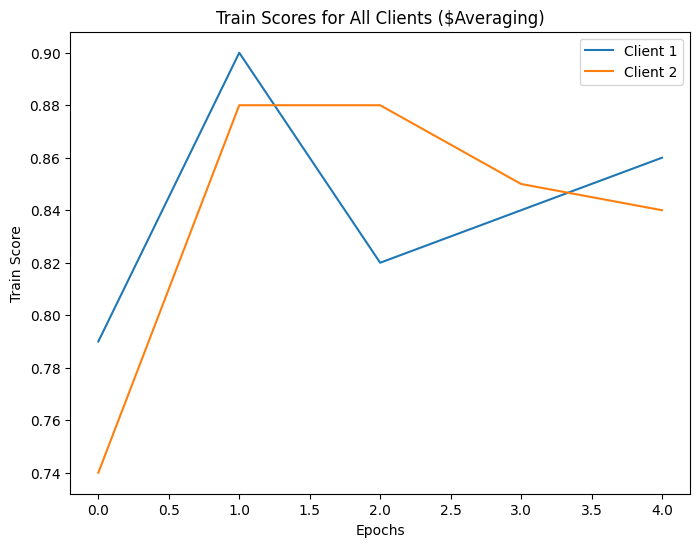

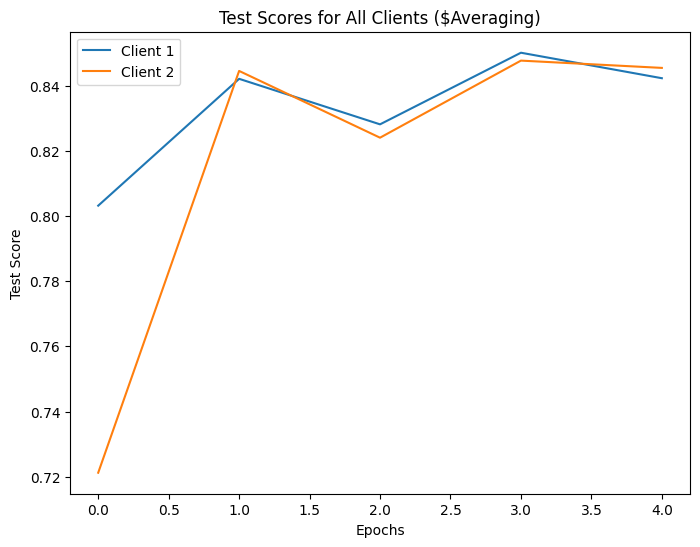

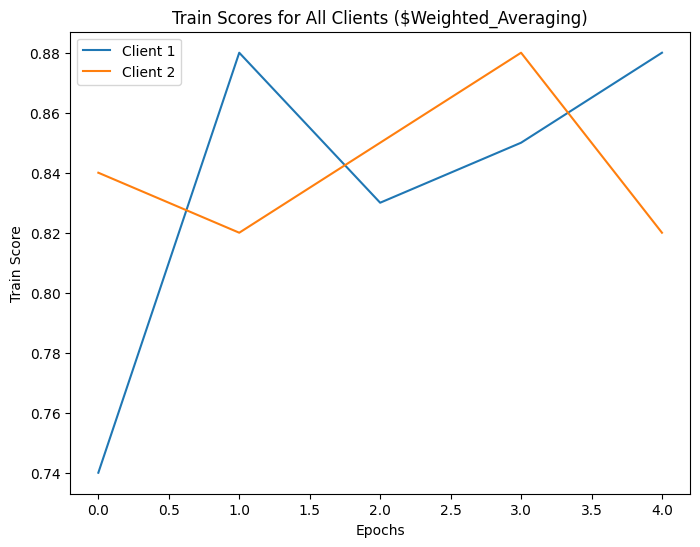

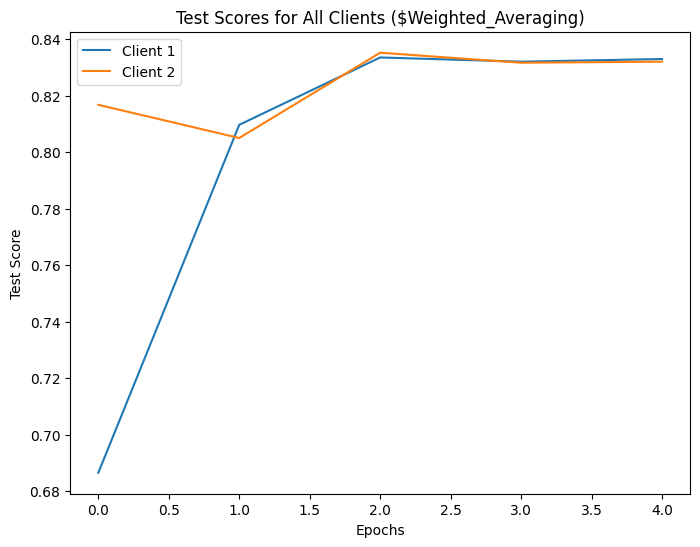

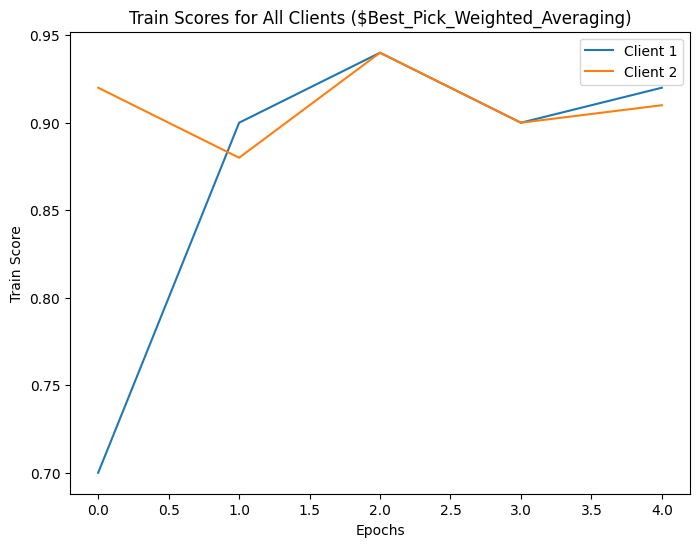

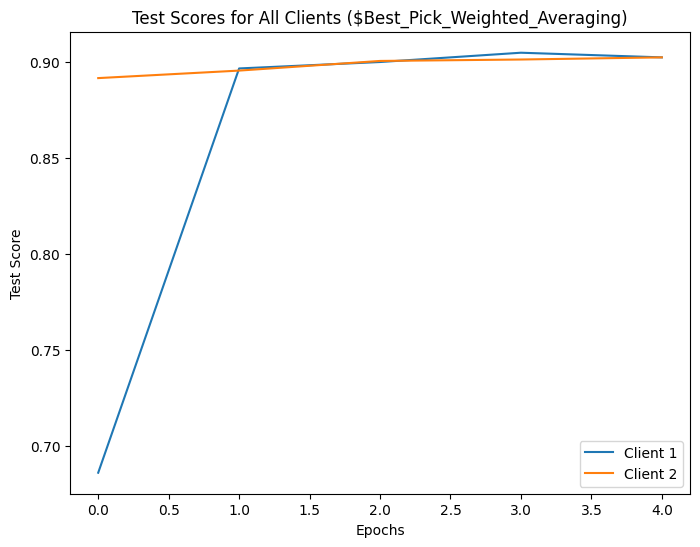

In [41]:
import matplotlib.pyplot as plt

# Create two figures, one for train scores and one for test scores

for idx, clients in enumerate(clients_2d_array):

  technique_name = list(fl_techniques.keys())[idx]
  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))

  # Plot train scores for all clients
  for client in clients:
      plt.plot(client.train_scores, label=f'Client {clients.index(client) + 1}')

  plt.xlabel('Epochs')
  plt.ylabel('Train Score')
  plt.title(f"Train Scores for All Clients (${technique_name})")
  plt.legend()

  # Show the train scores plot
  plt.show()

  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))

  # Plot test scores for all clients
  for client in clients:
      plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

  plt.xlabel('Epochs')
  plt.ylabel('Test Score')
  plt.title(f"Test Scores for All Clients (${technique_name})")
  plt.legend()

  # Show the test scores plot
  plt.show()


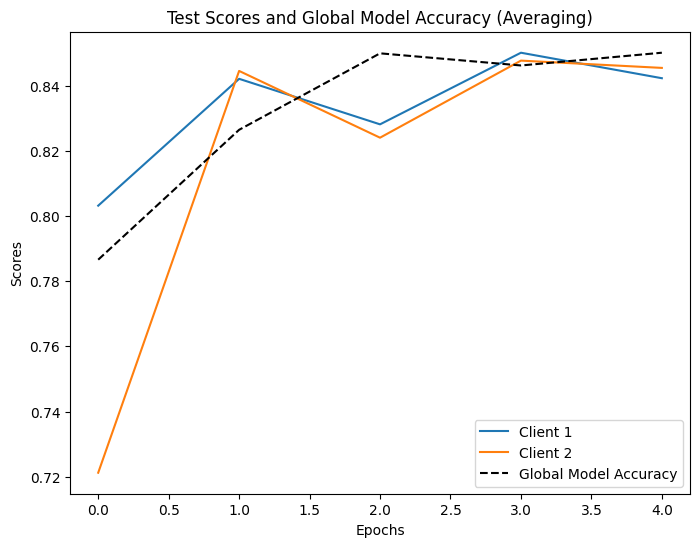

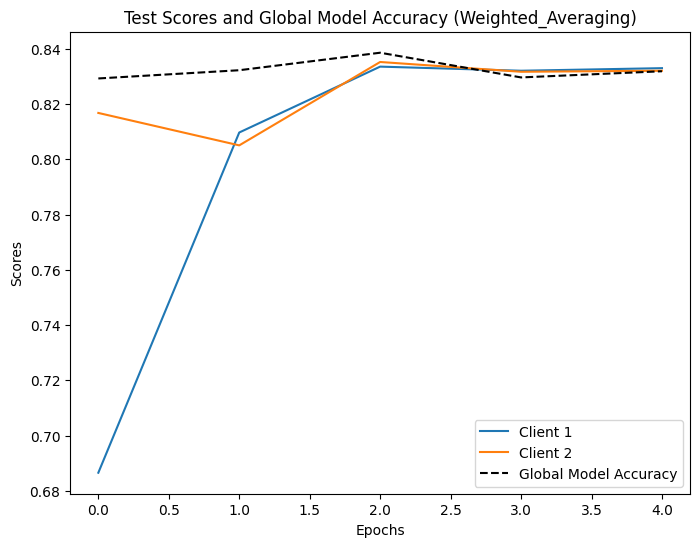

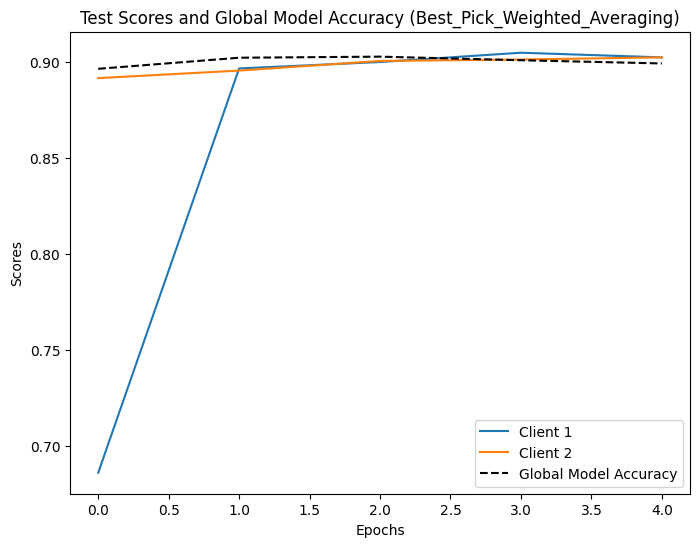

In [42]:
import matplotlib.pyplot as plt


for idx, clients in enumerate(clients_2d_array):

  technique_name = list(fl_techniques.keys())[idx]
  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))


  # Plot test scores for all clients
  for client in clients:
      plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

  # Plot global model accuracy
  plt.plot(global_model_accuracy[idx], label='Global Model Accuracy', linestyle='--', color='black')

  plt.xlabel('Epochs')
  plt.ylabel('Scores')
  plt.title(f"Test Scores and Global Model Accuracy ({technique_name})")
  plt.legend()

  # Show the combined graph
  plt.show()
